## 0) Import some libraries

In [511]:
#the very standard libs
import pandas as pd
import numpy as np
import time

# tensorflow and scikit libraries to play with neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, LeakyReLU

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.layers import BatchNormalization
# import tensorflow.keras.backend as K
# from tensorflow.keras.datasets import mnist

# use matplotlib to get nice graphs...
import matplotlib.pyplot as plt

# to get dynamlc plots
from IPython import display

## 1) let's define some functions to work with 

In [513]:
# define an array of "x" values and a corrresponding array of 'y' calculated from x
x1, y1 = [0,1], [1,0]
# x = np.arange(-50, 50, 0.1)
# y0 = 2*x + 25
# y1 = 0.1*x**3 - 80*np.sin(x/4)
# y2 = 0.2*x**3 + 3000*np.sin(x/6) - 1000*(x*[x>20]).reshape(len(x),)
# y3 = 0.002*x**4 + 2000*np.log(x + 600)
# y4 = 1+20000*np.sign(x)

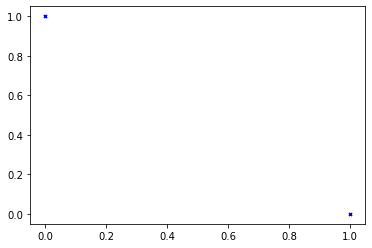

In [514]:
plt.scatter(x1, y1, marker = 'x', s=10, c = 'blue');
# plt.scatter(x, y1, marker = 'x', s=0.1, c = 'red');
# plt.scatter(x, y2, marker = 'x', s=0.1, c = 'green');
# plt.scatter(x, y3, marker = 'x', s=0.1, c = 'orange');
# plt.scatter(x, y4, marker = 'x', s=0.1, c = 'grey');

*** xy dataframe:
    x  y
0  0  1
1  1  0

*** xy.info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       2 non-null      int64
 1   y       2 non-null      int64
dtypes: int64(2)
memory usage: 160.0 bytes

*** xy.describe():
               x         y
count  2.000000  2.000000
mean   0.500000  0.500000
std    0.707107  0.707107
min    0.000000  0.000000
25%    0.250000  0.250000
50%    0.500000  0.500000
75%    0.750000  0.750000
max    1.000000  1.000000


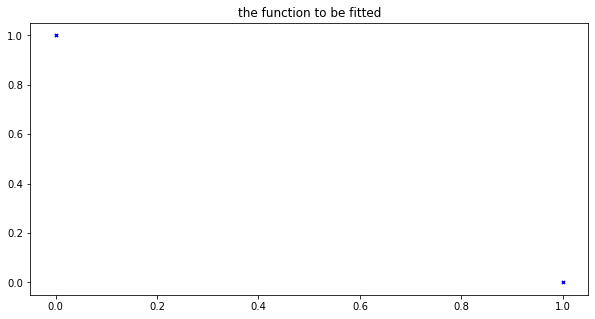

In [515]:
#select the y array to be fiited , get some info and plot the function
x = x1
y = y1

xy = pd.DataFrame({'x': x, 'y':y})
print('*** xy dataframe:\n', xy)
print('\n*** xy.info():\n')
xy.info()
print('\n*** xy.describe():\n', xy.describe())

#plot xy
plt.figure(figsize =(10, 5))
plt.title('the function to be fitted')
plt.scatter(x, y, marker = 'x', s=10, c = 'blue');


In [516]:
# add some "gussian" noise...
sd = 0 
noi = np.random.normal(0, sd, size = len(x))
y = y + noi

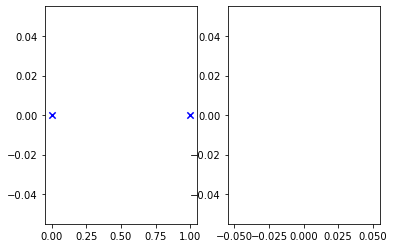

In [517]:
# plot noise and its histogram, 
plt.subplot(121)
plt.scatter(x, noi, marker = 'x', s=40, c = 'blue');
plt.subplot(122)
plt.hist(noi, np.arange(-3*sd, 3*sd, len(x)/200), color='r');

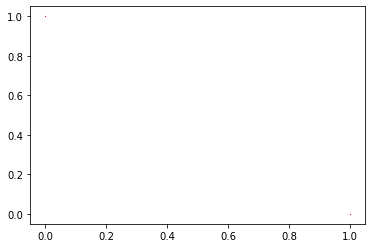

In [518]:
#plot x with/out noise
plt.scatter(x, y, marker = 'x', s=0.1, c = 'r');
plt.scatter(x, y - noi, marker = 'x', s=0.1, c = 'c', linewidth = 0.2);

## 2) Design the Neural Network model

In [519]:
# function to design the neural network model
# here we can play with the layer number, neuron number per layer, activation function type
# and also the learning rate, the loss metric

def nn_model():
    #following line to clear/reset the model
    tf.keras.backend.clear_session()

    my_model = Sequential()
    #input layer
    my_model.add(Dense(1, input_dim = 1, activation = 'sigmoid',use_bias=True,
#                        bias_initializer="ones", #optional. can be "zeros"
                       kernel_initializer="glorot_uniform",
                      ))

    #hidden layers (optional)
#     my_model.add(Dense(32, activation = 'relu'))
#     my_model.add(Dense(32, activation = 'sigmoid'))
#     my_model.add(Dense(25, activation = 'relu'))
#     my_model.add(Dense(32, activation = 'relu'))
#     my_model.add(Dense(32, activation = 'sigmoid'))
#     my_model.add(Dense(32, activation = 'sigmoid'))
#     my_model.add(Dense(10, activation = 'sigmoid'))
#     my_model.add(Dense(32, activation = 'relu'))

    #output layer
#     my_model.add(Dense(1, activation = 'linear'))

    #select the optimizer and define the learning rate
    opt = keras.optimizers.Adam(learning_rate = 0.03)
#     opt = keras.optimizers.RMSprop(learning_rate = 0.03)

    # define the loss function and optimization metrics
    my_model.compile(loss='mean_squared_error', metrics = ['mse', 'mean_absolute_error', 'mean_absolute_percentage_error'], optimizer = opt)

    # Display model architecture summary 

    return my_model

In [520]:
#function to return sigmoid(z)
def zf(z):
    return 1 / (1 + np.exp(-z))
#function to return some model output
def neur1(_model, x0, x1, p):
    _xy = np.array([x0, x1])
    _v = _xy * _model.get_weights()[0][0][0] + _model.get_weights()[1][0]
    _v_out = zf(_v)
    if p: print('w, b',_model.get_weights()[0][0][0],_model.get_weights()[1][0],'\nz=',_v,'\ng(z)=', _v_out)
    return _v, _v_out
def neur1_val(_model, x0, x1, exp0, exp1, *p):
    _expxy = np.array([exp0, exp1])
    _xy = np.array([x0, x1])
    _wg = np.array([_model.get_weights()[0][0][0], _model.get_weights()[1][0]])
    _v = _xy * _wg[0] + _wg[1]
    _v_out = zf(_v)
    _rmse = np.mean(abs(_v_out - [exp0,exp1]))
    _mse = np.mean((_v_out - [exp0 , exp1])**2)
    if p: print('[x1,x0]', '[w, b]','[z0, z1]', '[g(z0), g(z1)]', 'mse')

    return _xy, _wg, _v, _v_out, _mse, _expxy


### set "my_model" and plot the results

In [521]:
#assign a model to "my model", print summary
my_model = nn_model()
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [522]:
# to look at weight and bias
for i in my_model.trainable_variables:
    print (i)
my_model.get_weights()
my_model.get_weights()[0][0][0], my_model.get_weights()[1][0]

<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32>


(-0.76920605, 0.0)

In [523]:
#lets initiate the model (no training cycle yet)
y_pred = my_model.predict(xy.x)

#define xy_pred as the output of the model
xy_pred = pd.DataFrame({'x': xy.x, 'y': xy.y, 'y_pred':y_pred.reshape(y_pred.shape[0],)})

In [524]:
xy_pred

,x,y,y_pred
0,0,1,0.500000
1,1,0,0.316651


In [525]:
xy_pred.y_pred[0]

0.5

In [526]:
#same, using the neur1_val function
neur1_val(my_model, 0, 1, 1, 0, 1)

[x1,x0] [w, b] [z0, z1] [g(z0), g(z1)] mse


(array([0, 1]),
 array([-0.76920605,  0.        ], dtype=float32),
 array([ 0.        , -0.76920605]),
 array([0.5       , 0.31665088]),
 0.17513388966436916,
 array([1, 0]))

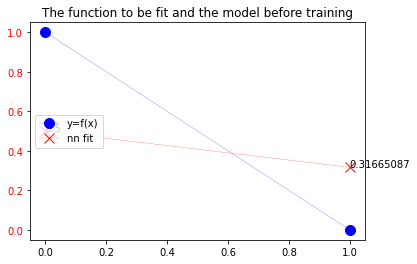

In [527]:
#let's plot the y and predicted at start...
plt.title('The function to be fit and the model before training')
plt.plot(xy_pred.x, xy_pred.y, c='b', marker='o', linewidth = 0.2, markersize=10)
plt.legend(['y=f(x)','nn fit'], loc='center left')
plt.yticks(c='b')
# plt.twinx()
plt.plot(xy_pred.x, xy_pred.y_pred, c='r', marker='x', linewidth = 0.2, markersize=10)
plt.annotate(xy = [xy_pred.x[0], xy_pred.y_pred[0]] ,  text=xy_pred.y_pred[0])
plt.annotate(xy = [xy_pred.x[1], xy_pred.y_pred[1]] ,  text=xy_pred.y_pred[1])

plt.legend(['nn fit'],loc='center right')
plt.legend(['y=f(x)','nn fit'], loc='center left')
plt.yticks(c='r');

### let's train the model with N cycles

In [528]:
#now let's "train" the model by playing with epochs (N)
t0 = time.time()
hist = my_model.fit(xy.x, xy.y, epochs = 1000, initial_epoch = 0, batch_size = 1, verbose = 0);
print('training time(s) =', round(time.time() - t0, 2))
pd.DataFrame.from_dict(hist.history)[-5:]


training time(s) = 2.85


,loss,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
995,0.000469,0.000469,0.021215,8428628.0
996,0.000468,0.000468,0.021194,8418440.0
997,0.000467,0.000467,0.021173,8408642.0
998,0.000467,0.000467,0.021155,8397288.0
999,0.000465,0.000465,0.021132,8393324.0


In [529]:
my_model.get_weights()

[array([[-7.716102]], dtype=float32), array([3.6446922], dtype=float32)]

In [530]:
neur1_val(my_model, 1, 0, 0, 1, 1)

[x1,x0] [w, b] [z0, z1] [g(z0), g(z1)] mse


(array([1, 0]),
 array([-7.716102 ,  3.6446922], dtype=float32),
 array([-4.07140994,  3.64469218]),
 array([0.01676739, 0.97453591]),
 0.00046478255890213075,
 array([0, 1]))

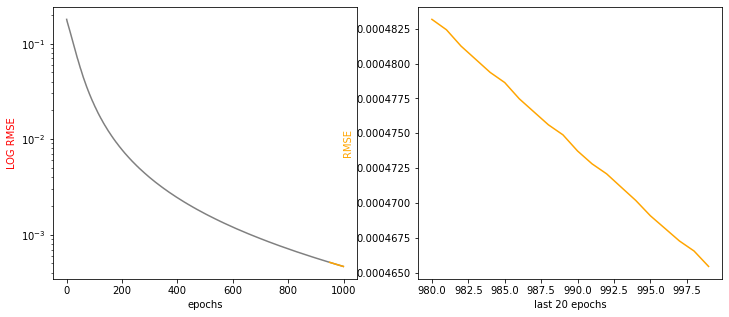

In [531]:
history_df = pd.DataFrame.from_dict(hist.history)
# sns.lineplot(data=history_df['root_mean_squared_error'])
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history_df.loss, c = 'grey')
plt.plot(history_df.loss[-50:], c = 'orange')
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("LOG RMSE", c='r');
plt.subplot(122)
plt.plot(history_df.loss[-20:], c='orange')
# plt.yscale('log')
plt.xlabel("last 20 epochs")
plt.ylabel("RMSE", c='orange');


    MSE: 0.000 
   RMSE: 0.022


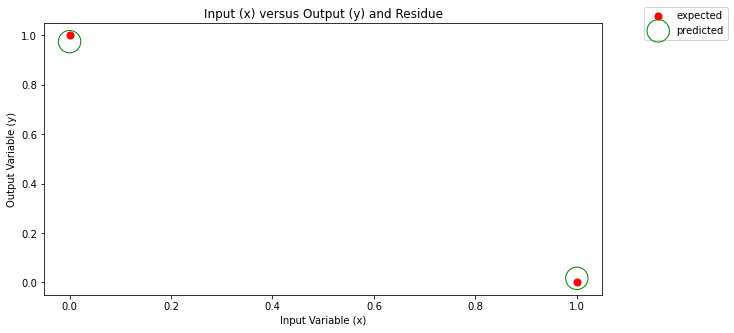

In [532]:
# make predictions for the input data
y_pred = my_model.predict(xy.x)
xy_pred = pd.DataFrame({'x': xy.x, 'y': xy.y, 'y_pred':y_pred.reshape(y_pred.shape[0],)})


#mse = ((xy_pred['y_pred']-y_mod)**2).mean()
mse = mean_squared_error(xy_pred['y'], xy_pred['y_pred'])
print('\n    MSE: %.3f' % mse, '\n   RMSE: %.3f' % mse**0.5)

x_plot = xy_pred.x
y_plot = xy_pred.y
y_pred_plot = xy_pred.y_pred 

plt.figure(figsize=(10,5))

plt.scatter(x_plot, y_plot , label='expected', s = 50, marker = 'o', c = 'r')
plt.scatter(x_plot,y_pred_plot , label='predicted', marker = 'o', color = 'g', facecolor = 'none', s = 500)
plt.title('Input (x) versus Output (y) and Residue')
plt.xlabel('Input Variable (x)')
plt.ylabel('Output Variable (y)')
plt.legend(loc='center', bbox_to_anchor = (1.15, 1))
plt.show()

## to see what happen during the training, let's make some loops

In [533]:
def test_epoch(x, y, ep, ini, sc = 0):
    hist = my_model.fit(x, y, epochs = ep, initial_epoch = ini, batch_size = 32, verbose = 0);
    history_df = (pd.DataFrame.from_dict(hist.history))
    return history_df


In [534]:
#reset model and train with ep=N step
ep = 0
my_model = nn_model()
loss0 = np.mean((neur1_val(my_model, 0, 1, 1, 0)[4]))
mae0 = np.mean(abs(neur1_val(my_model, 0, 1, 1, 0 )[3]-neur1_val(my_model, 0, 1, 1, 0)[5]))
full_hist = pd.DataFrame([[loss0, loss0, mae0, 100]],columns=['loss', 'mean_squared_error', 'mean_absolute_error',
       'mean_absolute_percentage_error'])
full_hist = full_hist.append(test_epoch(xy.x, xy.y, ep = ep, ini = 0)).reset_index(drop = True)
xy_plot_hist = pd.DataFrame(xy.x)
xy_plot_hist['0'] = xy.x * 0
y_pred_hist = pd.DataFrame([neur1_val(my_model, 0, 1, 1, 0)[3]])
xywbl_hist = pd.DataFrame([[neur1_val(my_model, 1, 0, 0, 1)[3][1],neur1_val(my_model, 1, 0, 0, 1)[3][0],neur1_val(my_model, 1, 0, 0, 1)[1][0],neur1_val(my_model, 1, 0, 0, 1)[1][1],loss0]], columns=['x0','x1','w', 'b', 'l'])

In [535]:
xy

,x,y
0,0,1
1,1,0


In [536]:
full_hist

,loss,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,0.440586,0.440586,0.647232,100


In [537]:
xywbl_hist

,x0,x1,w,b,l
0,0.5,0.794463,1.352042,0.0,0.440586


In [538]:
neur1_val(my_model, 0, 1, 1, 0, 1)

[x1,x0] [w, b] [z0, z1] [g(z0), g(z1)] mse


(array([0, 1]),
 array([1.3520418, 0.       ], dtype=float32),
 array([0.        , 1.35204184]),
 array([0.5       , 0.79446324]),
 0.4405859227690607,
 array([1, 0]))

In [539]:
# xy_plot_hist

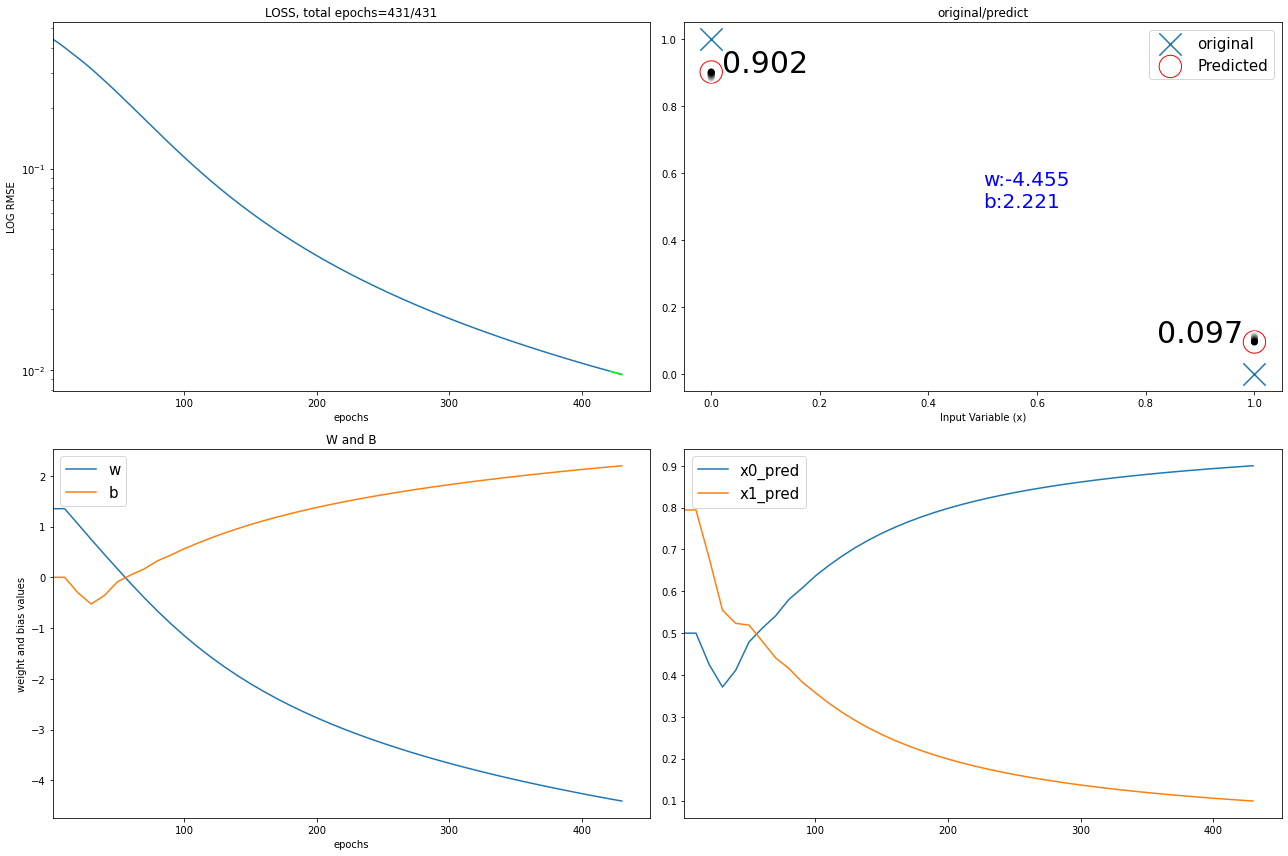

In [544]:
#design a loop to have a dynamic view
vws = 10
epo = 10
h = 10
hist_dot = np.arange(0, h)
pr = len(full_hist)
fh = xy_plot_hist.shape[1]

for i in range (0, vws+1):
    y_pred = my_model.predict(xy.x, verbose = 0)
    xy_pred = pd.DataFrame({'x': xy.x, 'y': xy.y, 'y_pred':y_pred.reshape(y_pred.shape[0],)})
    x_plot = xy_pred.x
    y_plot = xy_pred.y
    y_pred_plot = xy_pred.y_pred
    xy_plot_hist[str(i+fh-1)] = y_pred_plot
    mse = mean_squared_error(xy_pred['y'], xy_pred['y_pred'])
    mae = mean_absolute_error(xy_pred['y'], xy_pred['y_pred'])
    plt.figure(figsize=(18,12))

    plt.subplot(221)
    plt.plot(full_hist.loss)
    plt.plot(full_hist[-epo:].loss, c='lime')
    plt.yscale('log')
    plt.xlim(1,)
    plt.xlabel("epochs")
    plt.ylabel("LOG RMSE")
    plt.title('LOSS, total epochs=' + str(len(full_hist)) + '/' + str(pr+(vws)*epo))
    plt.subplot(223)
    plt.plot(xywbl_hist[['w', 'b']])
#     plt.annotate(str(round(full_hist.loss[-1:].values[0],3)), xy=[0.25,0.25], xycoords='figure fraction', size = 20)#[full_hist[-epo:].loss[0],full_hist[-epo:].loss[1]])
    plt.xlim(1,)
    plt.xlabel("epochs")
    plt.ylabel("weight and bias values")
    plt.title('W and B')
    plt.legend(['w','b'], fontsize = 15)

    plt.subplot(222)
    plt.scatter(x_plot, y_plot, label='original', marker = 'x', s = 500)
    plt.scatter(x_plot, y_pred_plot, label='Predicted', marker = 'o', color = 'r', facecolor = 'none', s = 500)
#     plt.scatter(x_plot, xy_plot_hist[[str(i+fh-2)]], label='prev Predicted', s = 100, c='gray')
#     plt.scatter(x_plot,  xy_plot_hist[xy_plot_hist.columns[-1:]], label='prev Predicted', s = 100, c='gray')
    if i>0:
        plt.scatter([0]*min(h,i), xy_plot_hist[xy_plot_hist.columns[-min(h,i):]][0:1], c=hist_dot[0:min(i,h)], cmap='gray_r')
        plt.scatter([1]*min(h,i), xy_plot_hist[xy_plot_hist.columns[-min(h,i):]][1:2], c=hist_dot[0:min(i,h)], cmap='gray_r')
    plt.annotate('' + str(round(y_pred_plot[0],3)), xy = [0.02, y_pred_plot[0]], size = 30)
    plt.annotate('' + str(round(y_pred_plot[1],3)), xy = [0.98, y_pred_plot[1]], size = 30, ha = 'right')
    n_w = my_model.get_weights()[0][0][0]
    n_b = my_model.get_weights()[1][0]
    plt.annotate('w:' + str(round(n_w,3)) + '\nb:' + str(round(n_b,3)),xy = [0.5, 0.5], size = 20, c='b')    
    plt.xlabel('Input Variable (x)')
    plt.title('original/predict')
    plt.legend(fontsize = 15)
    plt.subplot(224)
#     plt.scatter(xy_pred['x'], xy_pred['y'] - xy_pred['y_pred'], c = 'red', marker = "x", s=5)
#     plt.title('Residue' + ' RMSE:' + str(round(mse**0.5, 2)))
#     plt.xlabel('Input Variable (x)')
    plt.plot(xywbl_hist[['x0', 'x1']])
    plt.xlim(1,)
    plt.legend(['x0_pred','x1_pred'], fontsize = 15)
    rm = 'MSE:' + str(round(mse,2)) + '\nRMSE:'+str(round(mse**0.5,2))+'\nMAE:'+str(round(mae,2))
#     if i > 1:
#         plt.annotate(rm, xy = [0.5, (xy_pred['y'] - xy_pred['y_pred']).mean()])

    plt.tight_layout();
    
    display.display(plt.gcf())
    plt.close()
    display.clear_output(wait=True)
    full_hist = full_hist.append(test_epoch(xy.x, xy.y, epo, 0)).reset_index(drop=True)
    
    y_pred_hist = y_pred_hist.append(y_pred_plot).reset_index(drop=True)
    xywbl_hist = xywbl_hist.append({'x0':y_pred[0][0], 'x1':y_pred[1][0],'w':n_w, 'b':n_b,'l':full_hist.loss[-1:].values[0]}, ignore_index = True)
    xywbl_hist.index = xywbl_hist.index * epo

In [541]:
mse = mean_squared_error(xy_pred['y'], xy_pred['y_pred'])
mae = mean_absolute_error(xy_pred['y'], xy_pred['y_pred'])
print('\n    MSE: %.3f' % mse, '\n   RMSE: %.3f' % mse**0.5, '\n    MAE: %.3f' % mae)


    MSE: 0.113 
   RMSE: 0.336 
    MAE: 0.336
